# Imports and loading

In [1]:
import easyocr
import pickle
from  PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (24, 13.5)
from skimage.filters import threshold_niblack, threshold_sauvola
import random
import pandas as pd

In [2]:
reader = easyocr.Reader(['fr','en'])

In [3]:
with open("easyocr_best_rotation_result.pickle", "rb") as f:
    results = pickle.load(f)
with open("thresh_easyocr_preprocessed_result.pickle", "rb") as f:
    results_prep = pickle.load(f)

In [4]:
# checking if bboxes points are in the correct order
for result in results:
    if result[0][0][0] >= result[0][2][0] or result[0][0][1] >= result[0][2][1]:
        print(result)
        
for result in results_prep:
    if result[0][0][0] >= result[0][2][0] or result[0][0][1] >= result[0][2][1]:
        print(result)
print("Done.")

Done.


# Extracting and saving "unsure" bboxes

In [5]:
img = np.array(Image.open("cv_difficult.jpg").rotate(84.375, expand=True))

In [6]:
print("Results for original")
unsure_results = [result for result in results if result[2] <= 0.99]
print(len(unsure_results), "/", len(results))

print("Results for preprocessed")
unsure_results_prep = [result for result in results_prep if result[2] <= 0.99]
print(len(unsure_results_prep), "/", len(results))

Results for original
82 / 137
Results for preprocessed
100 / 137


In [7]:
def is_iterable(obj):
    if isinstance(obj, str):
        return False
    try:
        obj = iter(obj)
    except TypeError as te:
        return False
    return True

def extract_crops(arr: np.ndarray, bboxes: list):
    if not is_iterable(bboxes):
        bboxes = list(bboxes)
        
    return [arr[int(bbox[0][1]):int(bbox[2][1]+1), int(bbox[0][0]):int(bbox[2][0]+1)] for bbox in bboxes]

def show_img(img):
    fig, ax = plt.subplots()
    if img.ndim == 2:
        ax.imshow(img, cmap="Greys")
    else:
        ax.imshow(img)
    ax.axis("off")
    plt.show()

def show_all_img(imgs):
    
    c = int(len(imgs) ** 0.5)
    r = c if c**2 == len(imgs) else c + 1
    
    fig, axs = plt.subplots(r, c)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i < len(imgs):
            ax.imshow(imgs[i])
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

In [8]:
crops = extract_crops(img, [res[0] for res in unsure_results])
crops_prep = extract_crops(img, [res[0] for res in unsure_results_prep])

In [9]:
print(len(crops))
print(len(crops_prep))

82
100


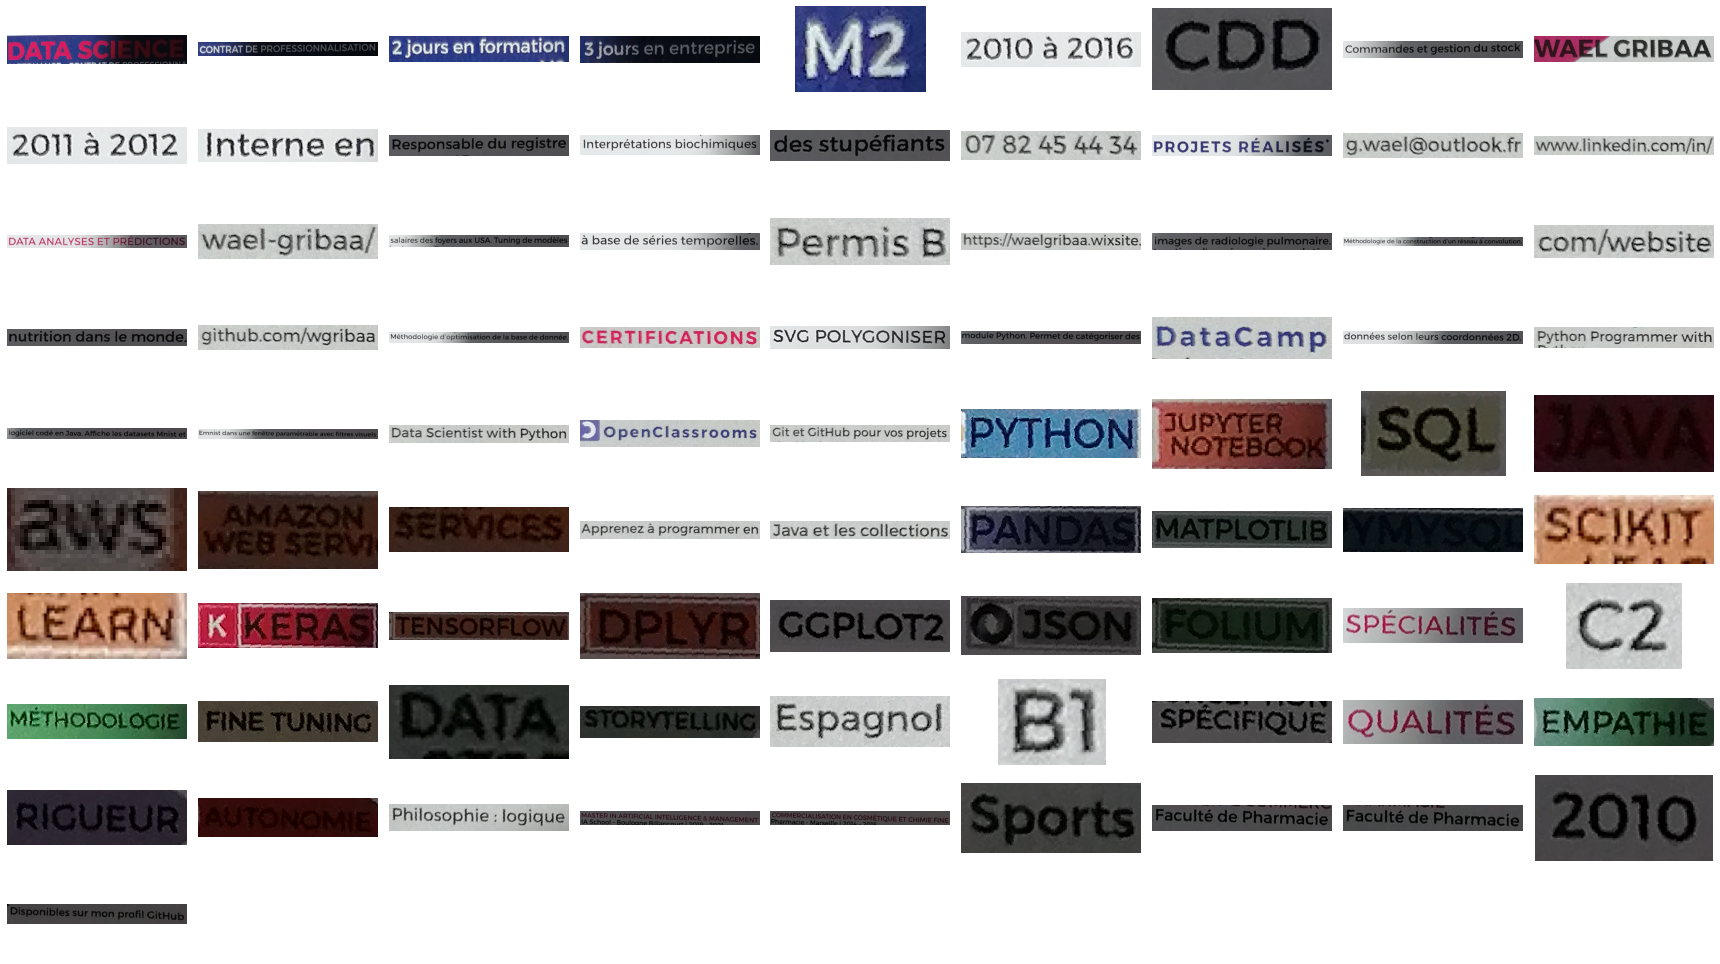

In [10]:
show_all_img(crops)

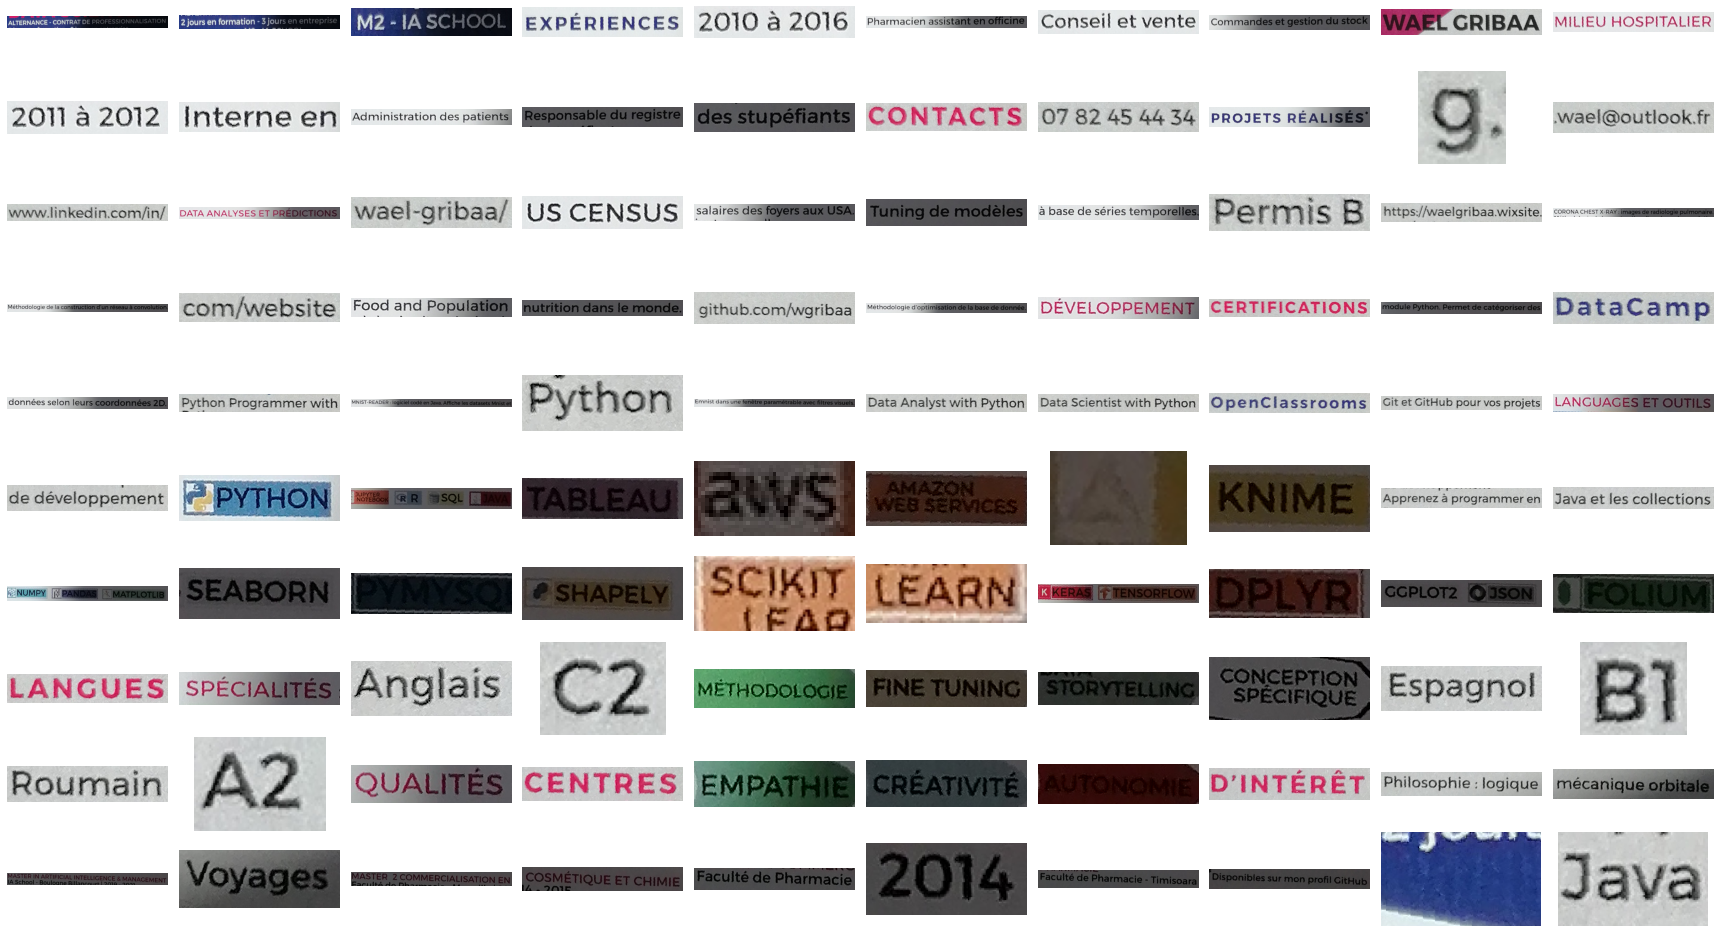

In [11]:
show_all_img(crops_prep)

# Detecting bbox collisions (aborted because of priorities and lack of time).

# Enhance crop readability

## Experimenting on one specific crop

In [12]:
unsure_results[0]

([[1411, 454], [2375, 454], [2375, 605], [1411, 605]],
 'DATAECA',
 0.03018855333013975)

In [13]:
def enhance(img):
    return cv2.medianBlur(
        cv2.adaptiveThreshold(
            cv2.GaussianBlur(
                cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (5, 5), 0),
            255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2),
        3)

In [14]:
def enhance2(img):
    x = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.float32(x < threshold_sauvola(x, window_size=255))

In [15]:
def enhance3(img):
    x = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x = np.array((x < threshold_sauvola(x, window_size=255))*255, dtype="uint8")
    return cv2.drawContours(img.copy(), cv2.findContours(x, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], -1, (255, 255, 255))

In [16]:
def enhance4(img):
    x = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    copy = img.copy()
    x = cv2.GaussianBlur(x,(5, 5), 1)
    x = np.array((x < threshold_niblack(x, window_size=255, k=0.15))*255, dtype="uint8")
    return cv2.drawContours(copy, cv2.findContours(x, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)[0], -1, (255,255,255), thickness=cv2.FILLED)

In [17]:
def enhance5_incorrect(img): #Obsolete: it is better to invert the HUE in HSV mode
    x = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    copy = img.copy()
    x = cv2.GaussianBlur(x,(5, 5), 1)
    x = np.array((x < threshold_niblack(x, window_size=255, k=0.15))*255, dtype="uint8")
        
    contours = cv2.findContours(x, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)[0]
    # get the mean hsv of the "inside" to apply the opposite color to the "outside" of contours
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.drawContours(mask, contours, -1, (255,255,255), -1)
    mean = cv2.mean(cv2.bitwise_not(img), mask=mask)
    
    return cv2.drawContours(copy, contours, -1, mean, thickness=cv2.FILLED)

In [18]:
def invert_hue(rgb_vals):
    # Takes the opposing Hue in HSV mode
    ret = cv2.cvtColor(rgb_vals, cv2.COLOR_BGR2HSV)
    return cv2.cvtColor(np.stack(((ret[...,0]+90) % 180, ret[..., 1], ret[..., 2]), 2), cv2.COLOR_HSV2BGR)

def enhance5(img):
    
    x = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    copy = img.copy()
    x = cv2.GaussianBlur(x,(5, 5), 1)
    x = np.array((x < threshold_niblack(x, window_size=255, k=0.15))*255, dtype="uint8")
        
    contours = cv2.findContours(x, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)[0]
    # Gets the mean of the "inside" to apply the opposite color to the "outside" of contours

    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.drawContours(mask, contours, -1, (255,255,255), -1)
    mean = cv2.mean(invert_hue(img), mask=mask)
    return cv2.drawContours(copy, contours, -1, mean, thickness=cv2.FILLED)

In [19]:
def show_steps(img, enhance_v5: bool = True):
    show_img(img)
    copy = img.copy()
    x = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     show_img(x)
    x = cv2.GaussianBlur(x,(5, 5), 1)
    show_img(x)
    x = np.array((x < threshold_niblack(x, window_size=255, k=0.15))*255, dtype="uint8")
    show_img(x)
    contours = cv2.findContours(x, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)[0]
    
    if enhance_v5:
#     Method enhance5
#     get the mean hsv of the "inside" to apply the opposite color to the "outside" of contours
        mask = np.zeros(img.shape[:2], np.uint8)
        cv2.drawContours(mask, contours, -1, (255,255,255), thickness=cv2.FILLED)
        mean = cv2.mean(invert_hue(img), mask=mask)
    else:
    # Method enhance4
        mean = (255,255,255)
    
    x = cv2.drawContours(copy, contours, -1, mean, thickness=cv2.FILLED)
    show_img(x)
#     x = cv2.Canny(x, 30, 200)
#     show_img(x)
#     return x

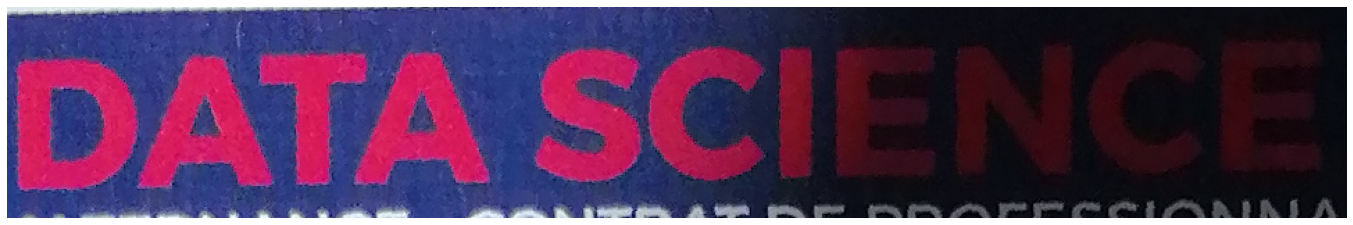

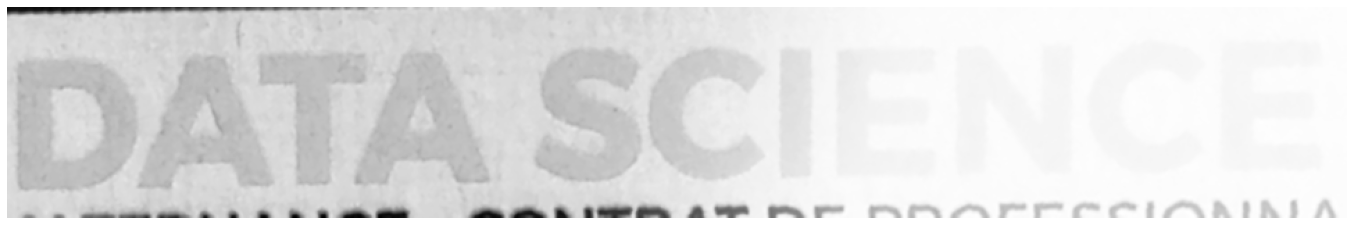

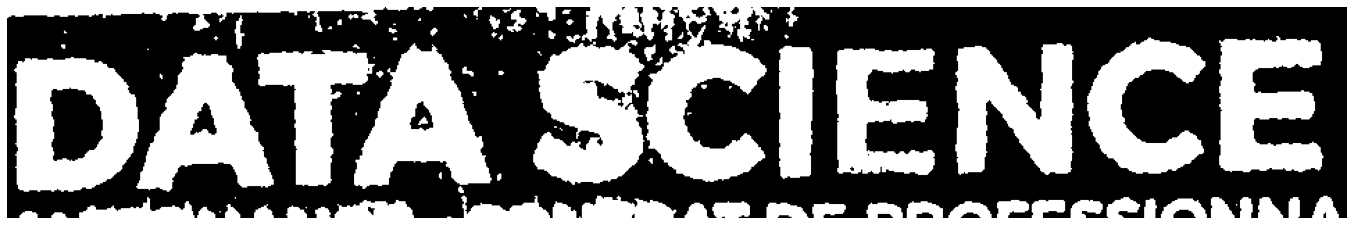

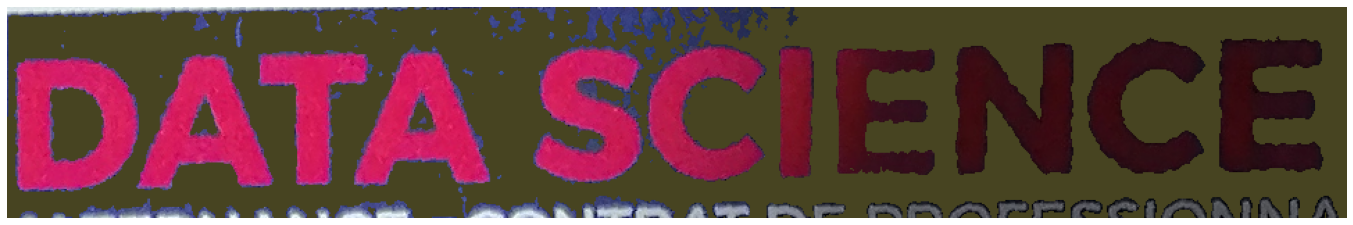

In [20]:
show_steps(crops[0])

In [21]:
def show_comparison(crop, unsure_result):
    enhanced_crop = enhance5(crop) #also try enhance5
    print("Before")
    show_img(crop)
    print(unsure_result)
    print("\n\nAfter")
    show_img(enhanced_crop)
    enhanced_result = reader.readtext(enhanced_crop)
    print(enhanced_result)
    
def take_comparison(crops, unsure_results, idx: int = None):
    ri = random.randint(0, len(crops) - 1) if idx is None else idx
    print("Index =", ri)
    show_comparison(crops[ri], unsure_results[ri])

Before


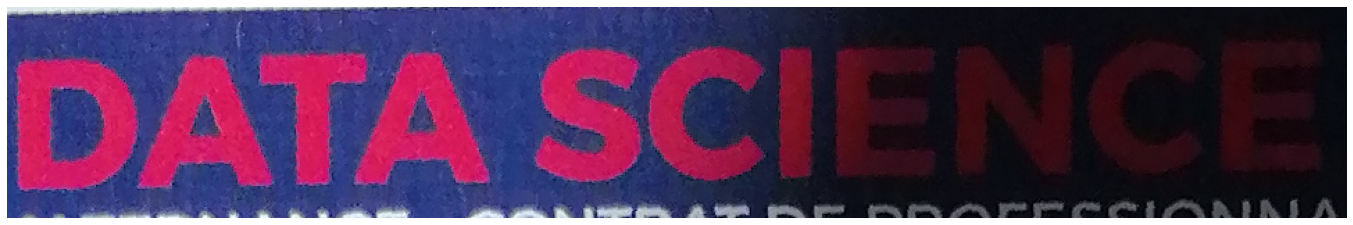

([[1411, 454], [2375, 454], [2375, 605], [1411, 605]], 'DATAECA', 0.03018855333013975)


After


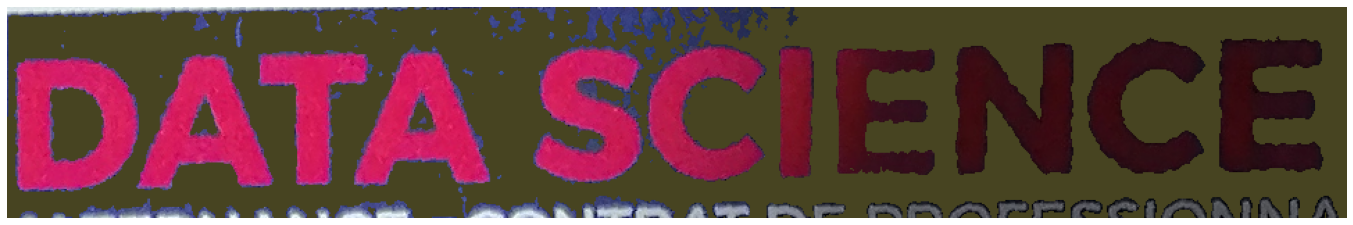

[([[2, 1], [965, 1], [965, 147], [2, 147]], 'DATA SCIENCE', 0.6360667679667065)]


In [22]:
show_comparison(crops[0], unsure_results[0])

Index = 24
Before


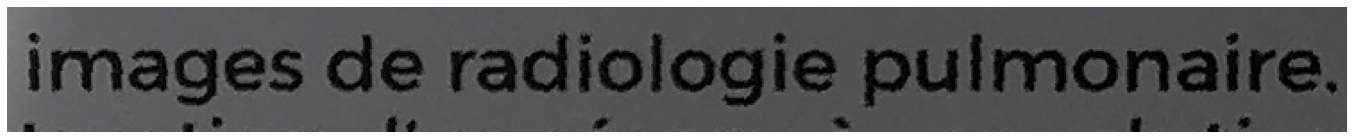

([[1716, 1763], [2464, 1763], [2464, 1832], [1716, 1832]], 'images de radiologie pulmonaire.', 0.7784929678116711)


After


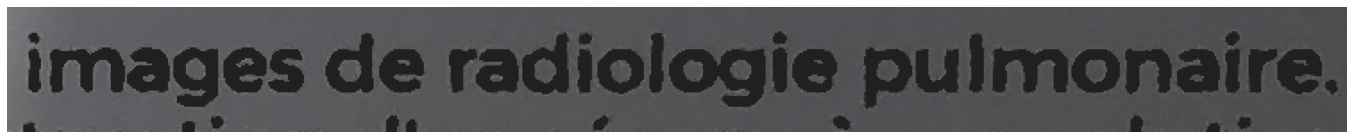

[([[1, 1], [749, 1], [749, 70], [1, 70]], 'images de radiologie pulmonaire.', 0.6498857528165907)]


In [23]:
take_comparison(crops, unsure_results)

## Applying the treatment to all crops and predicting

In [24]:
def clean_result(result):
    if len(result) == 0:
        return [None, None, None]
    elif len(result) == 1:
        return result[0]
    else:
        try:
            result[1][0]
            return result[0]
        except:
            return [None, None, None]

def max_result(result1, result2):
    if result1[2] is None:
        return result2
    if result2[2] is None:
        return result1
    return result1 if result1[2] > result2[2] else result2

In [25]:
compare = []
final_crops = []
for crop, unsure_result in zip(crops, unsure_results):
    enhanced_crop4 = enhance4(crop)
    enhanced_crop5 = enhance5(crop)
    enhanced_result4 = reader.readtext(enhanced_crop4)
    enhanced_result5 = reader.readtext(enhanced_crop5)
    enhanced_result = max_result(
        clean_result(enhanced_result4),
        clean_result(enhanced_result5)
    )

    compare.append({"before": unsure_result[1], "conf_before": unsure_result[2],
                   "after": enhanced_result[1], "conf_after": enhanced_result[2]})
    final_crops.append(enhanced_crop4 if enhanced_result == enhanced_result4 else enhanced_crop5) 

In [26]:
compare_df = pd.DataFrame(compare)
compare_df

before  conf_before  \
0                              DATAECA     0.030189   
1      CONTRAT DE PROFESSIONNALISATION     0.811179   
2                 2 jours en formation     0.841411   
3                3 jours en entreprise     0.906851   
4                                   M2     0.878265   
..                                 ...          ...   
77                              Sports     0.776682   
78                Faculté de Pharmacie     0.985026   
79                Faculté de Pharmacie     0.989282   
80                                2010     0.751631   
81  'Disponibles sur mon profil CitHub     0.978515   

                                after  conf_after  
0                        DATA SCIENCE    0.756890  
1     CONTRAT DE PROFESSIONNALISATION    0.993065  
2                2 jours en formation    0.984956  
3               3 jours en entreprise    0.901350  
4                                  M2    0.852666  
..                                ...         ...  
77                             Sports    0.999898  
78               Faculté de Pharmacie    0.809906  
79               Faculté de Pharmacie    0.972609  
80                               2010    0.997285  
81  'Dlsponiblos sur mon pronl GltHub    0.539000  

[82 rows x 4 columns]

In [27]:
compare_df[compare_df.conf_after > compare_df.conf_before]

before  conf_before  \
0                                          DATAECA     0.030189   
1                  CONTRAT DE PROFESSIONNALISATION     0.811179   
2                             2 jours en formation     0.841411   
6                                              CDD     0.787104   
8                                      WAEL GRIBAA     0.577238   
10                                      Interne en     0.904231   
11                         Responsable du registre     0.661954   
12                    Interprétations biochimiques     0.887665   
13                                 des stupéfiants     0.715324   
14                                  07 82 45 44 34     0.688415   
16                               g.wael@outlook fr     0.903341   
17                             wwwlinkedin com/in/     0.660037   
19                                    wael-gribaal     0.962944   
22                                        Permis B     0.732821   
23                      https://waelgribaa.wixsite     0.740313   
26                                     com/website     0.644208   
30                                  CERTIFICATIONS     0.732769   
32        module Python. Permet de catégoriser des     0.743851   
33                                        DataCamp     0.942035   
34             données selon leurs coordonnées 2D.     0.623563   
38                      Data Scientist with Python     0.871334   
42                                       J7874580K     0.038702   
43                                            ISQL     0.703767   
44                                           Fres2     0.000231   
47                                            e g      0.004037   
50                                         IPANDA]     0.254371   
51                                      MATPLOTLIB     0.923848   
52                                                     0.000000   
55                                        K KERA 7     0.096053   
56                                     ITENSORELOW     0.557210   
61                                     SPÉCIALITÉS     0.913208   
62                                              C2     0.762544   
67                                        Espagnol     0.889634   
71                                        EMPATHIE     0.950850   
72                                         RicUEUR     0.261550   
73                               Psars Haicieiallz     0.000009   
74                           Philosophie : logique     0.888973   
75   MASTERIN ARTIFICIAL INTELLICENCE & MANAGEMENT     0.724001   
76  FOMMERCIALISATION EN COSMÉTIQUE ET CHIMIE FINE     0.679689   
77                                          Sports     0.776682   
80                                            2010     0.751631   

                                            after  conf_after  
0                                    DATA SCIENCE    0.756890  
1                 CONTRAT DE PROFESSIONNALISATION    0.993065  
2                            2 jours en formation    0.984956  
6                                             CDD    0.999778  
8                                     WAZL GRIBAA    0.631730  
10                                     Interne en    0.999373  
11                        Responsable du registre    0.971248  
12                    Interprétations biochimique    0.908034  
13                                des stupéfiants    0.925852  
14                                 07 82 45 44 34    0.900411  
16                              g.wael@outlook fr    0.909548  
17                            wwwlinkedin comfinl    0.717406  
19                                   wael-gribaal    0.993843  
22                                       Permis B    0.995405  
23                      https /kaelgribaa wixsite    0.864248  
26                                     comkebsite    0.900943  
30                                 CERTIFICATIONS    0.983765  
32       module Python. Permet de catégoriser des    0.862801  
33           

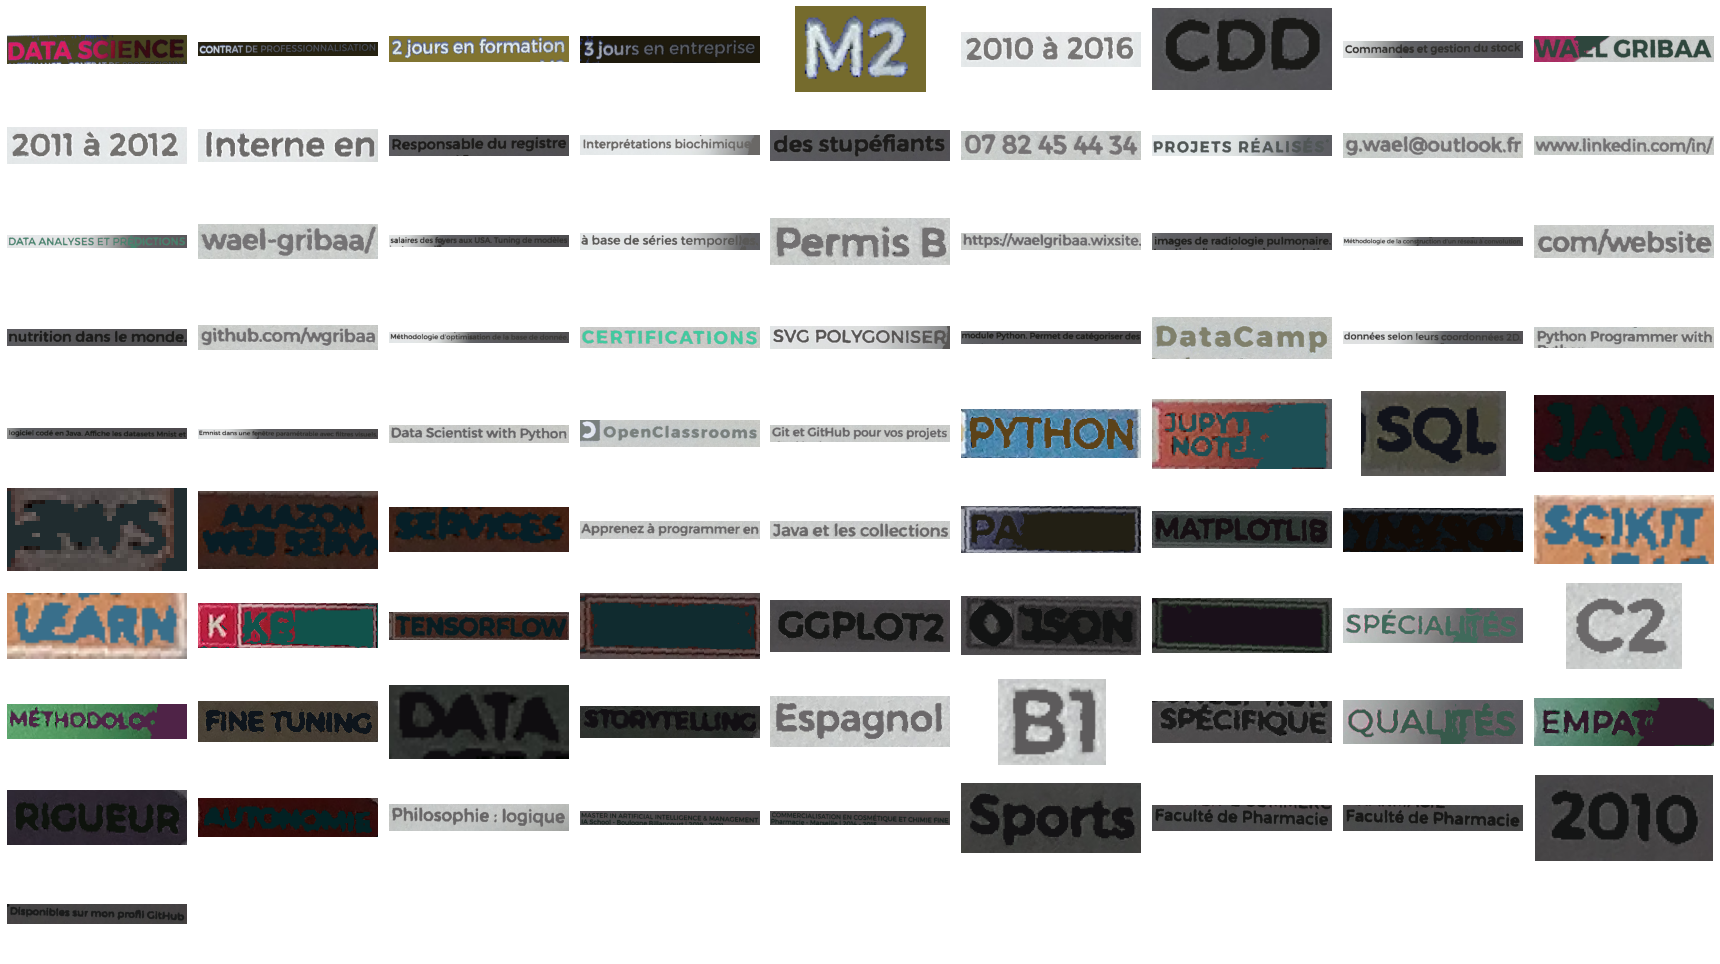

In [28]:
show_all_img(final_crops)